# 1. Test w/ a PNG

Overall goal: Generate statistics from a bunch of pages of sheet music and the right hand music for various pieces--take lines, generate column vectors after separating a line of music into columns that tell if there is a note there or not (middle C to C above the staff line, anything higher than that just goes into the same class)--get a distribution for which vectors are most common and see if among these pieces this algorithm will be discriminative enough.

In [1]:
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
os.getcwd()

'/data1/dbashir/Project/Summer2018'

In [12]:
# load image
test_image = Image.open(os.path.join("prepped_png_danielcopy", "bwv871_vfinale", "bwv871_vfinale-1.png")).convert('L')

In [13]:
img_array = np.array(test_image)
#plt.imshow(img_array)
img_array.shape

(792, 612)

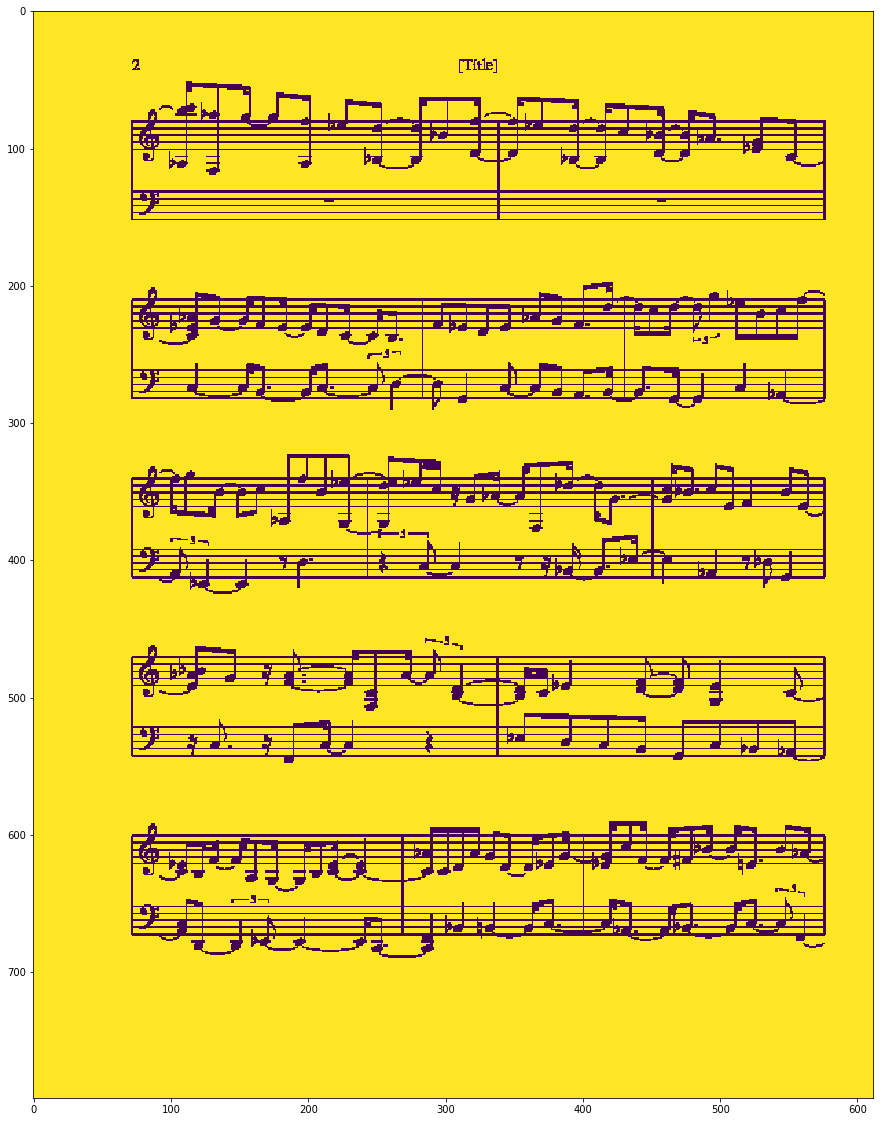

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(img_array)

Let's see if we can get the top row.

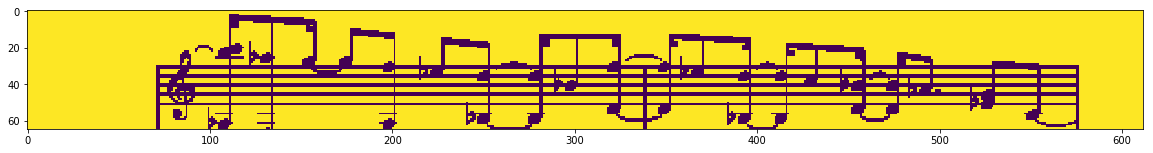

In [21]:
plt.figure(figsize=(20,20))
plt.imshow(img_array[50:115, :])

Nice! We got a row. Now let's see if we can convert this to a set of vectors or smth.

Let's start EZ and see if we can do this with just one column

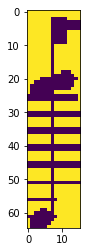

In [40]:
plt.imshow(img_array[50:115, 104:120])

In [41]:
column_test_one = img_array[50:115, 104:120]

Ok so it appears that we can divy this up into rows that are 5 pixels tall and get something out of that. There will be 13 of these in our image.

In [42]:
print(column_test_one)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255   0   0 ... 255 255 255]
 [255   0   0 ... 255 255 255]
 [255   0   0 ... 255 255 255]]


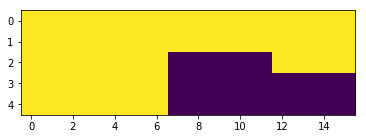

In [43]:
plt.imshow(column_test_one[0:5, :])

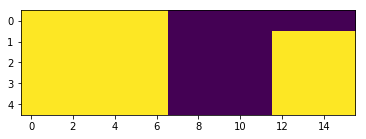

In [44]:
plt.imshow(column_test_one[5:10, :])

In [45]:
not_a_note_location_one = column_test_one[0:5, :]
not_a_note_location_two = column_test_one[5:10, :]

In [46]:
print("location one: \n")
print(not_a_note_location_one)

location one: 

[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255   0   0   0   0   0 255 255 255 255]
 [255 255 255 255 255 255 255   0   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255   0   0   0   0   0   0   0   0   0]]


In [47]:
np.unique(not_a_note_location_one, return_counts=True) 

(array([  0, 255], dtype=uint8), array([23, 57]))

So out of 100 pixels above, 23 have value 0 and 57 have value 255. THE ZEROS ARE THE DARK THINGS THAT ARE NOTES. 

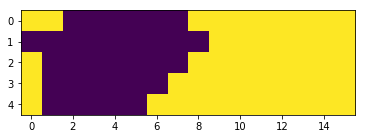

In [48]:
plt.imshow(column_test_one[60:65, :])

In [49]:
note_location_bottom = column_test_one[60:65, :]

In [50]:
print(note_location_bottom)

[[255 255   0   0   0   0   0   0 255 255 255 255 255 255 255 255]
 [  0   0   0   0   0   0   0   0   0 255 255 255 255 255 255 255]
 [255   0   0   0   0   0   0   0 255 255 255 255 255 255 255 255]
 [255   0   0   0   0   0   0 255 255 255 255 255 255 255 255 255]
 [255   0   0   0   0   0 255 255 255 255 255 255 255 255 255 255]]


In [51]:
np.unique(note_location_bottom, return_counts=True)

(array([  0, 255], dtype=uint8), array([33, 47]))

Ok so it was 33 (total of 80) "note pixels" in this case. Let's try another and come up with a manual cutoff for when we should say one of des thingies is a notey

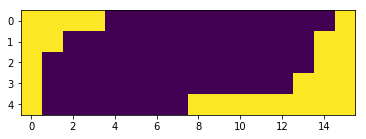

In [52]:
plt.imshow(column_test_one[20:25, :])

In [53]:
note_location_top = column_test_one[20:25, :]

In [54]:
print(note_location_top)

[[255 255 255 255   0   0   0   0   0   0   0   0   0   0   0 255]
 [255 255   0   0   0   0   0   0   0   0   0   0   0   0 255 255]
 [255   0   0   0   0   0   0   0   0   0   0   0   0   0 255 255]
 [255   0   0   0   0   0   0   0   0   0   0   0   0 255 255 255]
 [255   0   0   0   0   0   0   0 255 255 255 255 255 255 255 255]]


In [55]:
np.unique(note_location_top, return_counts=True)

(array([  0, 255], dtype=uint8), array([55, 25]))

In [58]:
note, counts = np.unique(note_location_top, return_counts=True)

In [59]:
counts

array([55, 25])

In [60]:
counts[0]

55

In [61]:
counts[0] + counts[1]

80

In [62]:
(counts[0] / (counts[0] + counts[1])) > 3/8

True

In this case it was 55 "note pixels". Let's play with a cutoff of 30, and iterate thru column_test_one and like x:x+5 where x goes from 0 to height - 5

In [74]:
note_location_matrices = []

In [57]:
len(column_test_one)

65

Ok so height is 65.

In [75]:
is_note_cutoff = 7/16
loop_increment = 5 # we'll iterate our loop and increment by 5 pixels

for x in range(0, len(column_test_one) - 5, loop_increment):
    candidate_location = column_test_one[x:x+5, :]
    note, counts = np.unique(candidate_location, return_counts=True)
    num_note_pixels = counts[0]
    total_pixels = counts[0] + counts[1]
    if (num_note_pixels / total_pixels) > is_note_cutoff:
        note_location_matrices.append(candidate_location)

In [68]:
len(note_location_matrices)

6

In [76]:
note_location_matrices[0]

array([[255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 255],
       [255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        255, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255,
        255, 255, 255]], dtype=uint8)

In [77]:
np.unique(note_location_matrices[1], return_counts=True)

IndexError: list index out of range

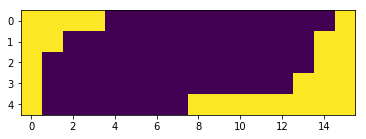

In [78]:
for note_location in note_location_matrices:
    plt.imshow(note_location)
    plt.show()

# Use notehead detector?

In [79]:
model_directory = 'models/fullModel.h5'

In [80]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D

Using TensorFlow backend.
/home/dbashir/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [81]:
def getModel_convcommon2():
    model = Sequential([
        BatchNormalization(input_shape=(15, 15, 1)),
        Conv2D(8, 3, 3, activation='relu'),
        Conv2D(8, 3, 3, activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(8, 1, 1, activation='relu'),
        Conv2D(8, 1, 1, activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(8, 1, 1, activation='relu'),
        Conv2D(8, 1, 1, activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(225, activation = 'relu'),
        Dense(225, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ])
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [82]:
test_model = getModel_convcommon2()

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu")`
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu")`
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), activation="relu")`
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), activation="relu")`
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), activation="relu")`
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__

In [83]:
test_model.load_weights(model_directory)

In [90]:
des_row = img_array[50:115, 0:600]

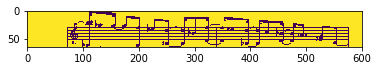

In [91]:
plt.imshow(des_row)

In [86]:
step_size = 15

In [94]:
window_size = (15,15)

In [92]:
des_row.shape

(65, 600)

In [105]:
windows = []

In [108]:
for y in range(0, des_row.shape[0], step_size):
    for x in range(0, des_row.shape[1], step_size):
        # get window
        window = des_row[y : y + window_size[1], x : x + window_size[0]]
        if window.shape == (15,15):
            windows.append(window)

In [109]:
windows[0].shape

(15, 15)

In [110]:
predictions = []
prediction_windows = []

In [118]:
for window in windows:
    (height, width) = (window.shape[0], window.shape[1])
    #print("height: " + str(height))
    window_reshaped = window.reshape(1, height, width, 1)
    #print("reshaped to: " + str(window_reshaped.shape))
    #print(test_model.predict(window_reshaped))
    prediction = int(test_model.predict(window_reshaped)[0][0])
    if prediction == 1:
        prediction_windows.append(window)

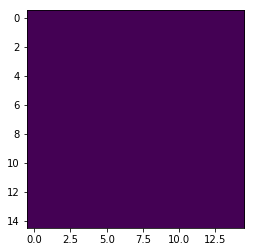

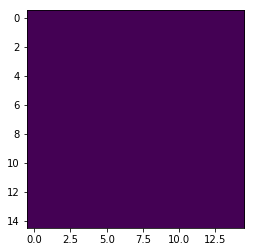

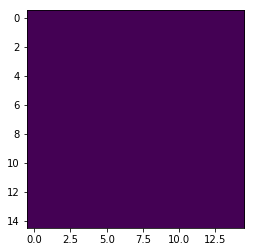

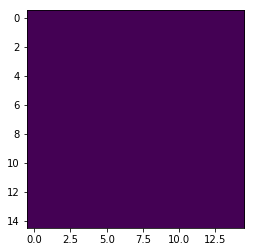

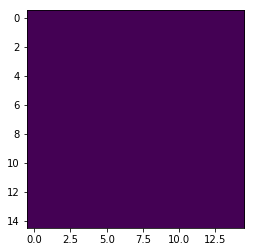

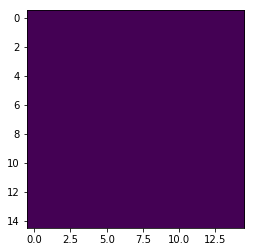

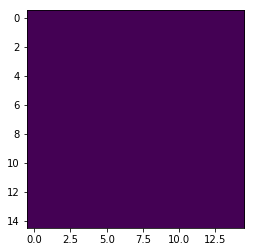

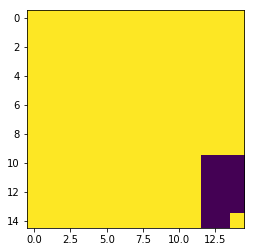

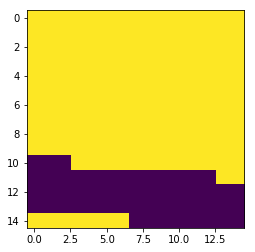

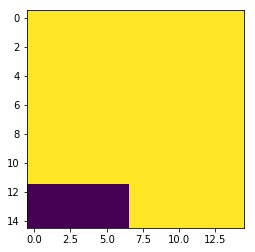

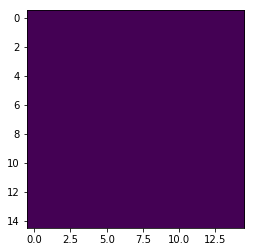

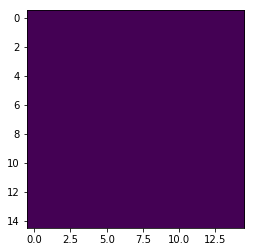

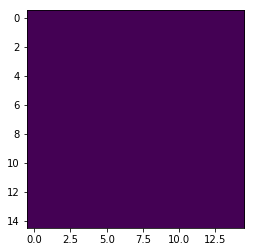

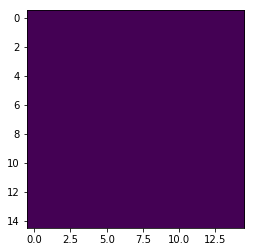

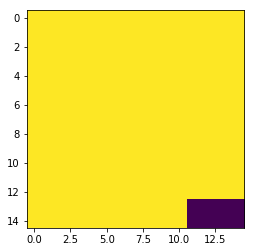

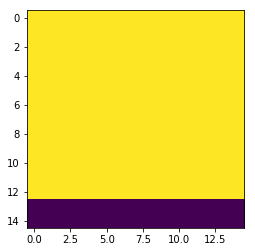

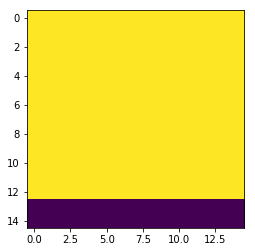

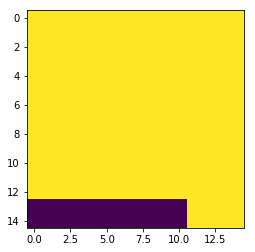

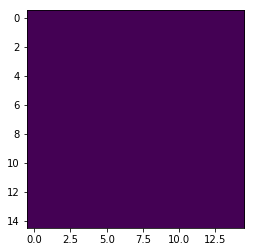

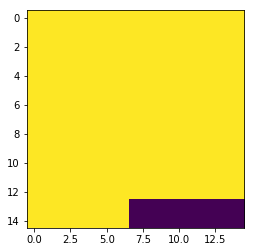

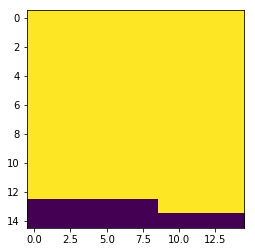

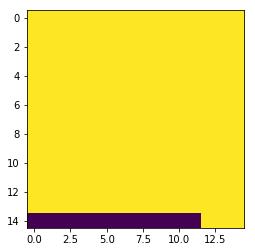

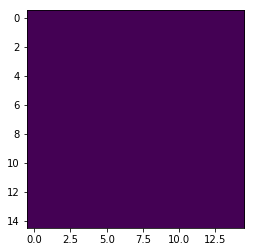

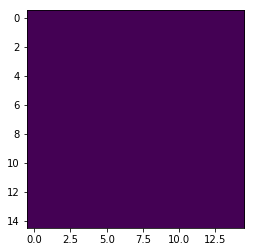

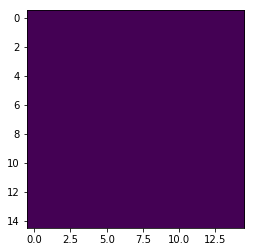

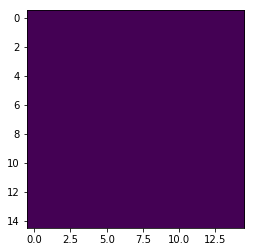

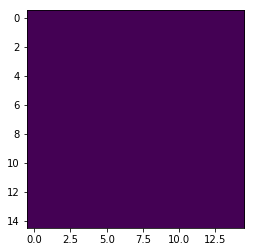

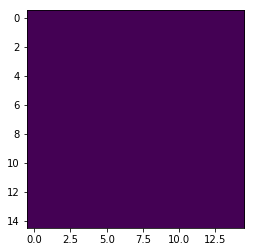

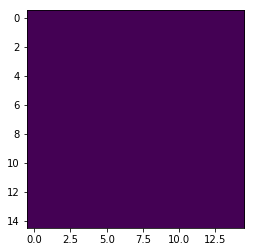

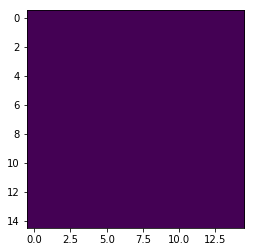

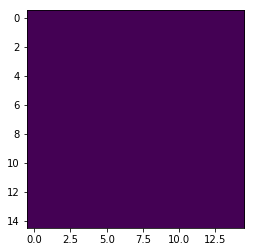

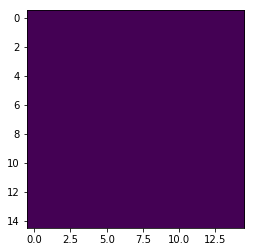

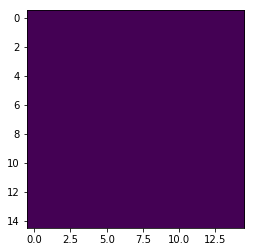

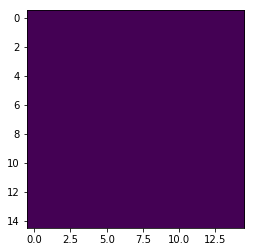

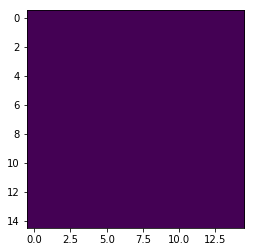

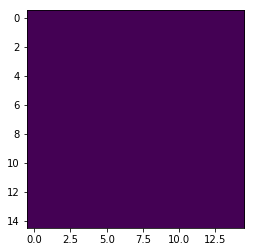

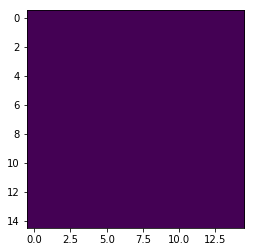

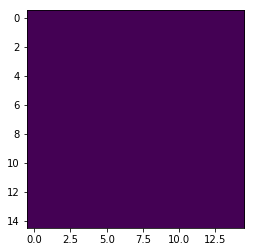

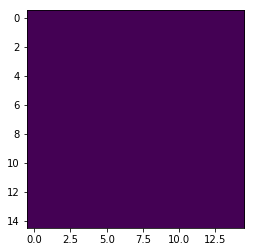

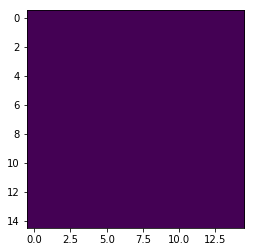

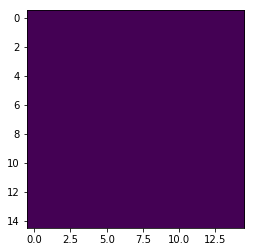

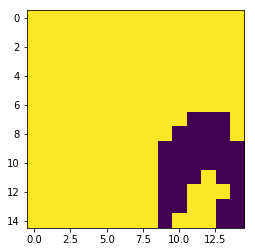

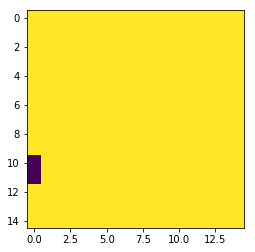

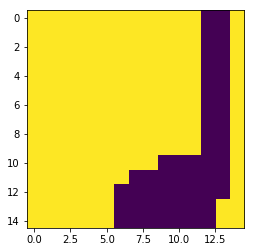

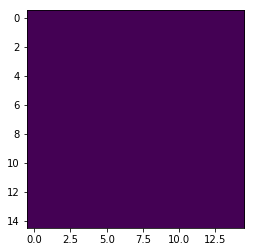

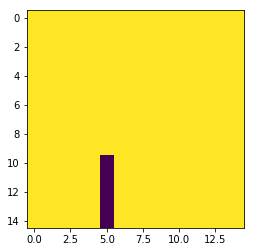

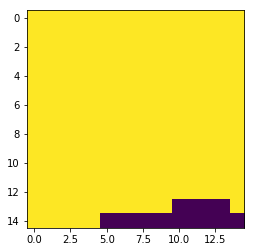

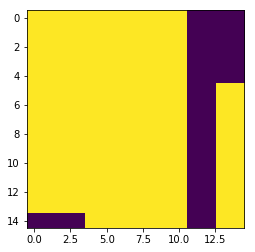

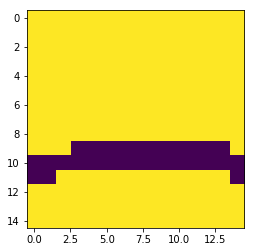

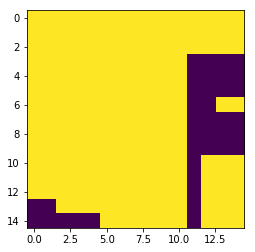

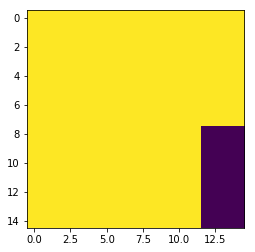

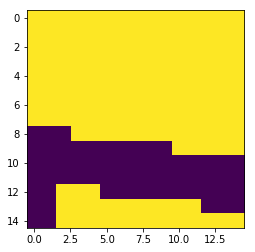

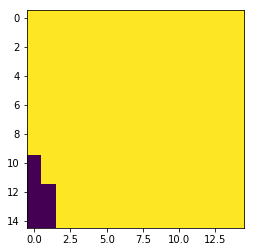

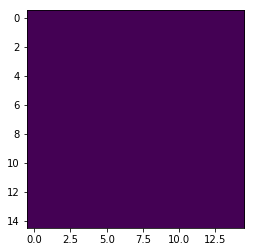

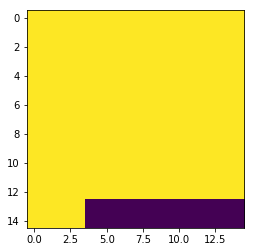

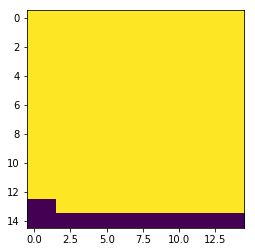

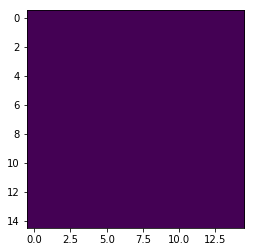

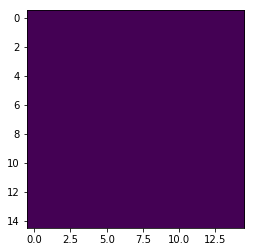

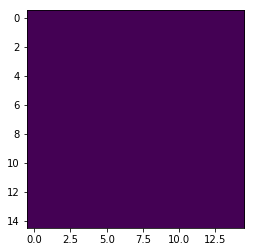

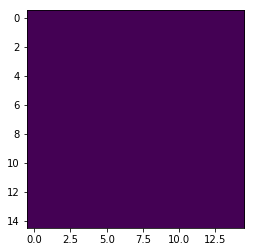

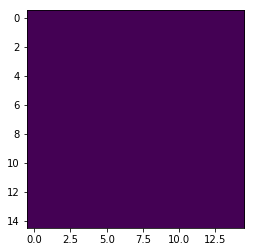

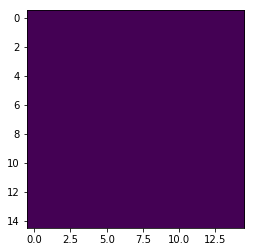

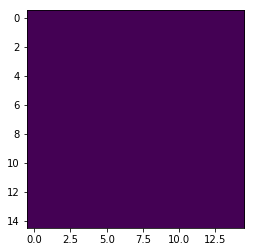

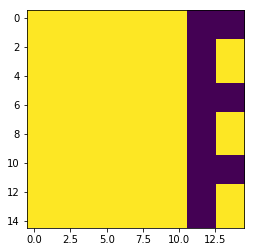

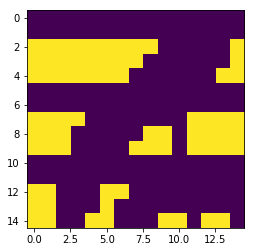

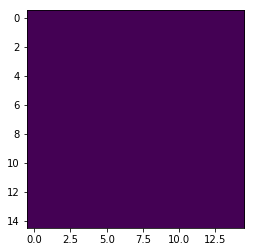

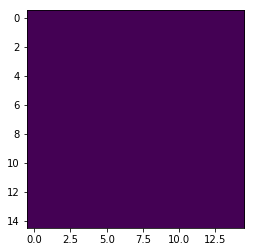

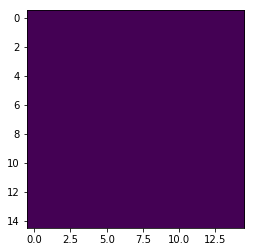

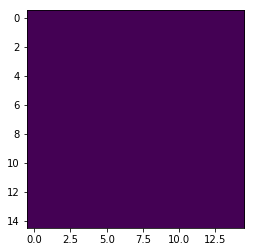

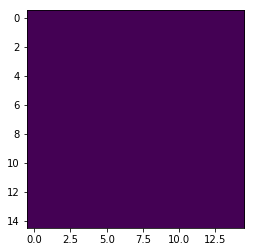

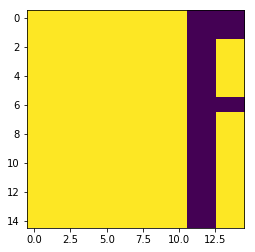

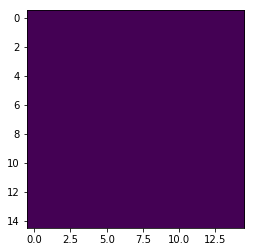

In [119]:
for predicted_note in prediction_windows:
    plt.imshow(predicted_note)
    plt.show()

# Split up single row into 15-width columns

That wasn't working too well. Let's first grab the top row we were working with earlier, create an array of column-patches of width 15 and play around with those. 

In [125]:
des_row_columns = []

In [121]:
des_row.shape

(65, 600)

In [128]:
np.unique(des_row, return_counts=True)

(array([  0, 255], dtype=uint8), array([ 8055, 30945]))

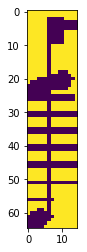

In [133]:
plt.imshow(des_row[ : , 105 : 120 ])

In [135]:
for x_loc in range(0, des_row.shape[1]-15, 15):
    #print("x value: " + str(x_loc))
    column = des_row[ : , x_loc : x_loc + 15 ]
    #print(np.unique(column, return_counts=True))
#     plt.imshow(column)
#     plt.show(0)
    des_row_columns.append(column)

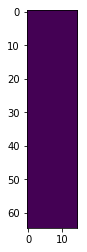

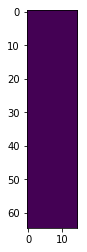

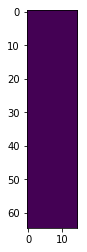

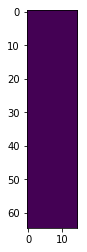

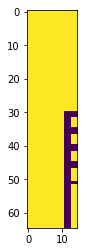

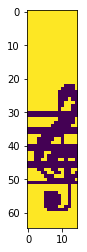

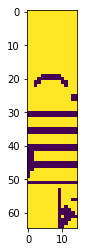

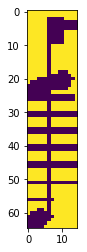

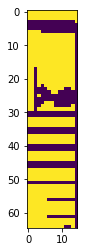

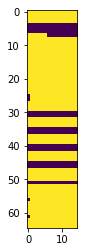

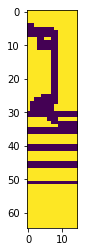

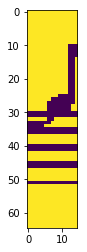

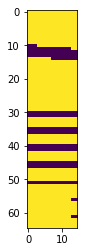

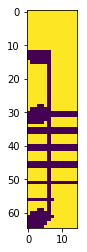

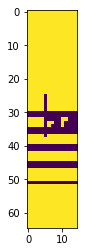

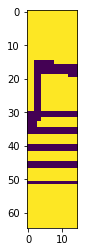

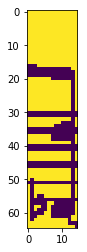

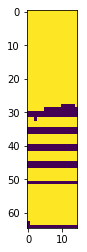

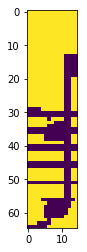

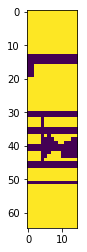

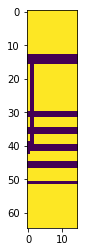

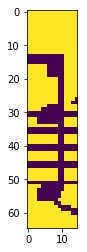

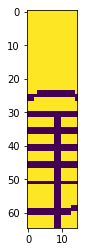

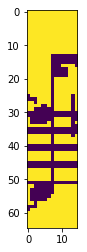

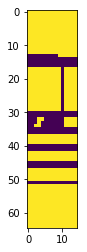

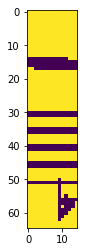

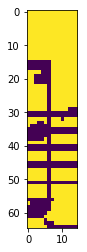

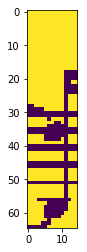

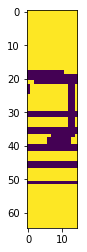

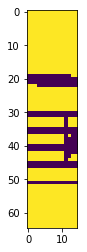

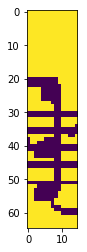

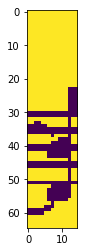

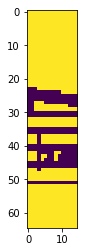

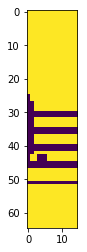

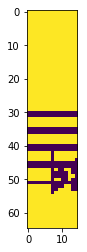

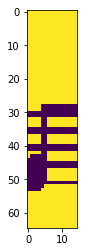

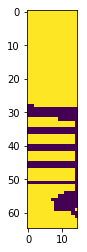

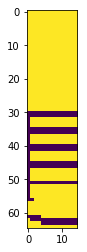

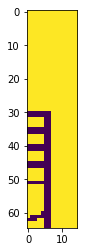

In [136]:
for column in des_row_columns:
    plt.imshow(column)
    plt.show()

In [137]:
for column in des_row_columns:
    print(np.unique(column, return_counts=True))

(array([255], dtype=uint8), array([975]))
(array([255], dtype=uint8), array([975]))
(array([255], dtype=uint8), array([975]))
(array([255], dtype=uint8), array([975]))
(array([  0, 255], dtype=uint8), array([ 88, 887]))
(array([  0, 255], dtype=uint8), array([299, 676]))
(array([  0, 255], dtype=uint8), array([201, 774]))
(array([  0, 255], dtype=uint8), array([354, 621]))
(array([  0, 255], dtype=uint8), array([320, 655]))
(array([  0, 255], dtype=uint8), array([193, 782]))
(array([  0, 255], dtype=uint8), array([262, 713]))
(array([  0, 255], dtype=uint8), array([217, 758]))
(array([  0, 255], dtype=uint8), array([193, 782]))
(array([  0, 255], dtype=uint8), array([256, 719]))
(array([  0, 255], dtype=uint8), array([164, 811]))
(array([  0, 255], dtype=uint8), array([215, 760]))
(array([  0, 255], dtype=uint8), array([310, 665]))
(array([  0, 255], dtype=uint8), array([166, 809]))
(array([  0, 255], dtype=uint8), array([298, 677]))
(array([  0, 255], dtype=uint8), array([224, 751]))


In [138]:
column_windows = []

Let's make this a 2-D array where each column has its own array of windows and those arrays get appended to column_windows.

In [139]:
for column in des_row_columns:
    column_wind = []
    for y in range(0, column.shape[0], step_size):
        # get window
        window = column[y : y + window_size[1], : ]
        if window.shape == (15,15):
            column_wind.append(window)
    column_windows.append(column_wind)

In [142]:
len(column_windows[0])

4

Makes sense. We wouldn't have the (5,15) window since we ditched that and so there should be 4 windows of size (15,15)

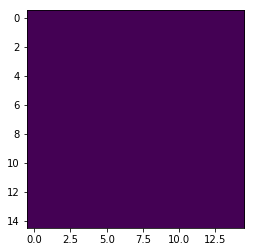

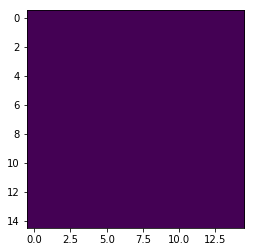

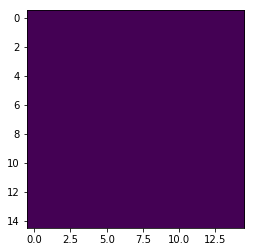

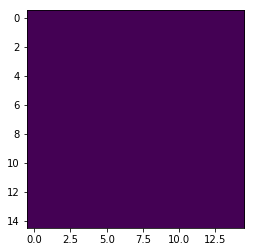

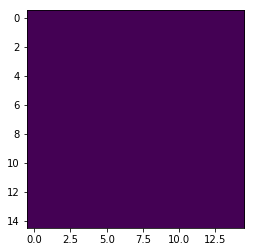

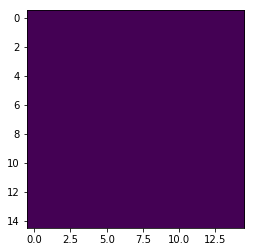

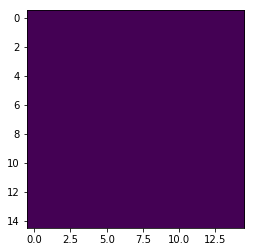

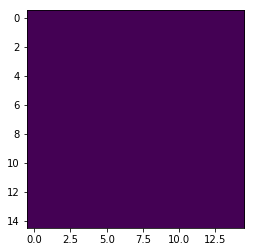

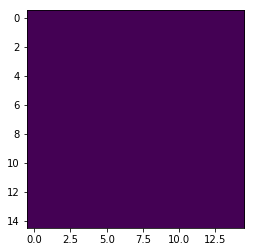

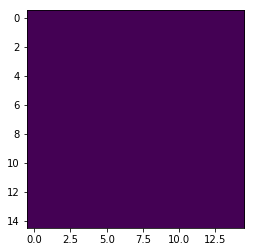

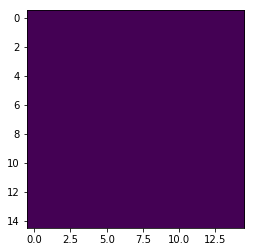

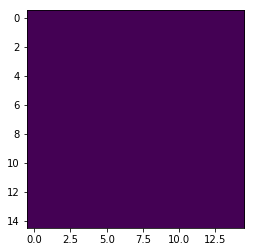

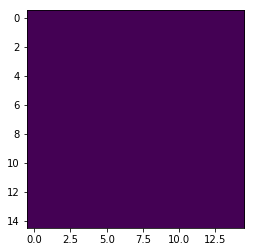

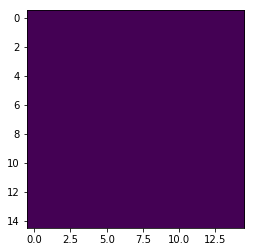

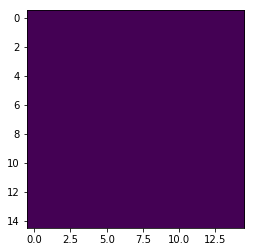

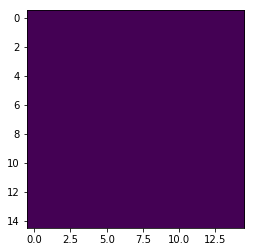

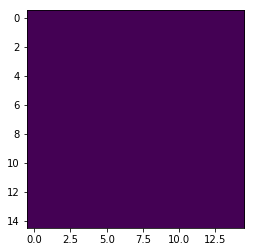

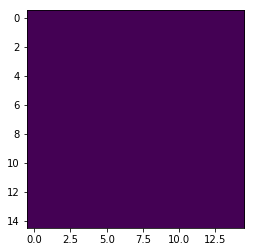

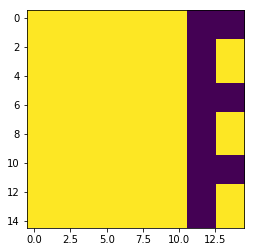

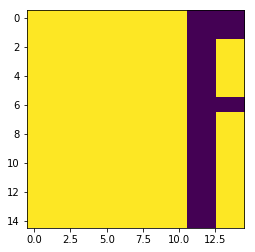

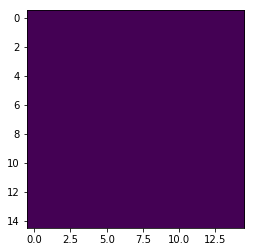

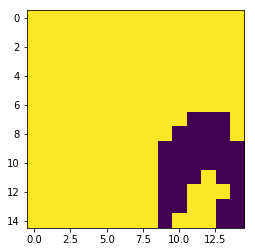

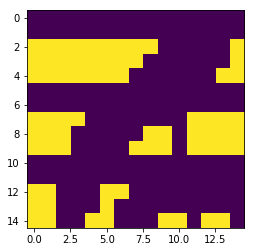

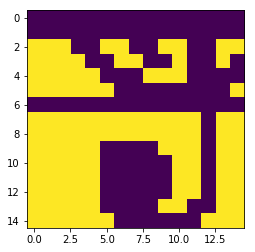

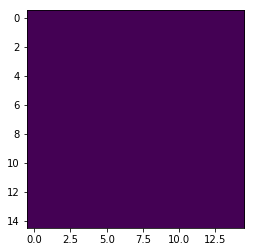

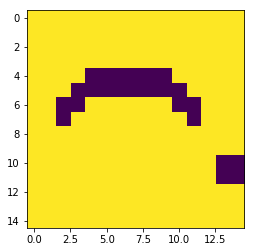

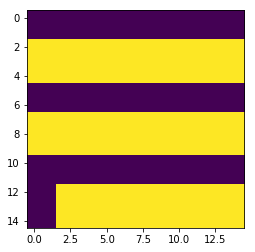

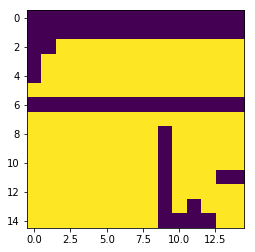

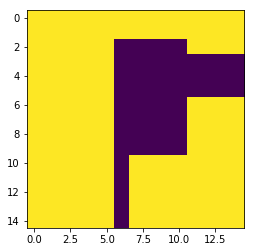

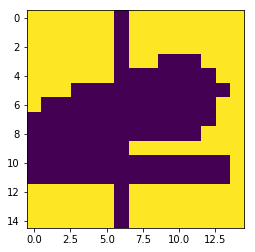

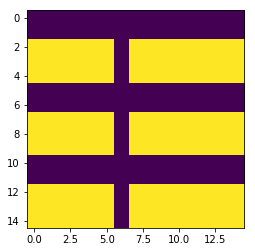

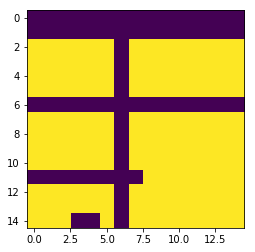

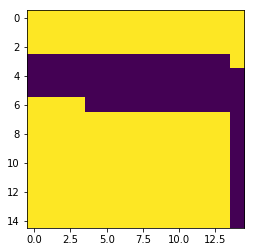

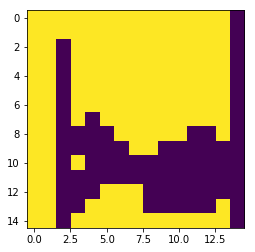

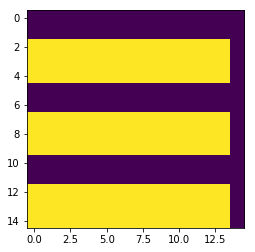

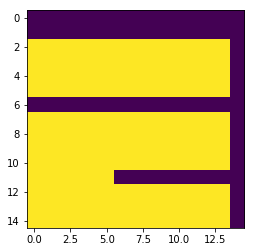

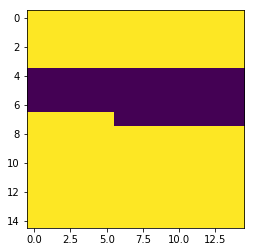

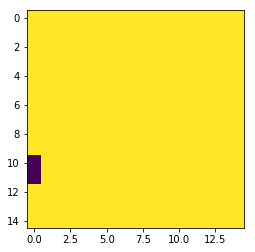

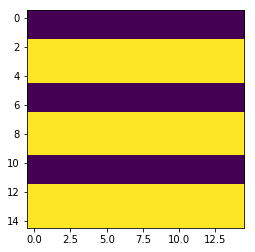

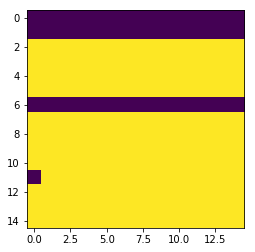

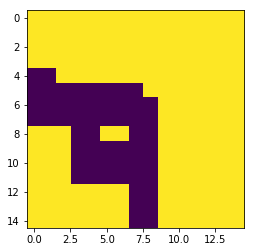

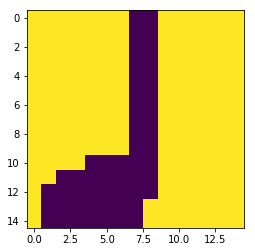

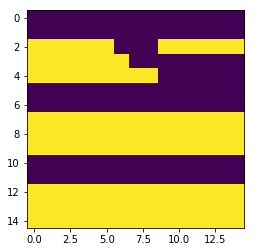

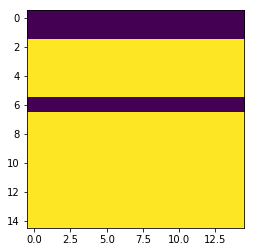

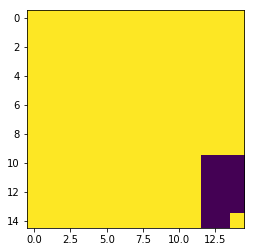

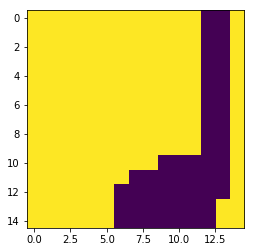

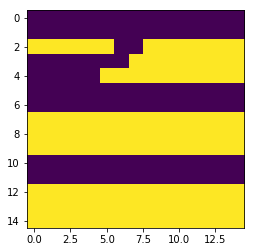

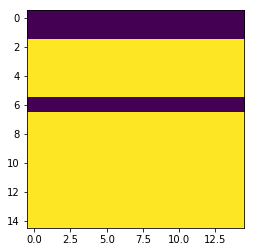

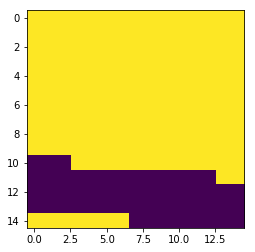

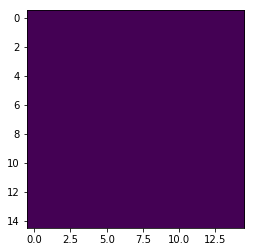

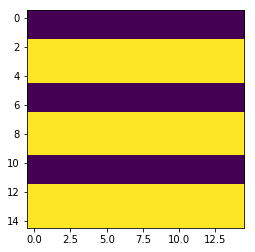

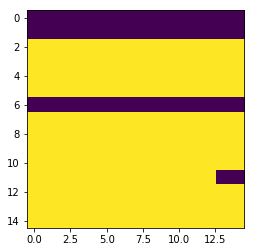

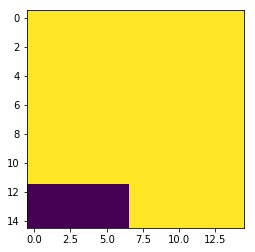

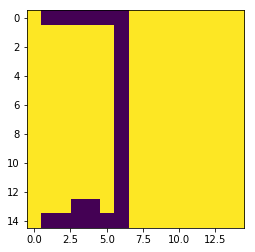

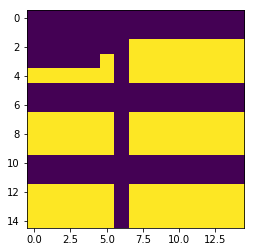

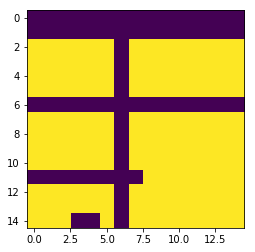

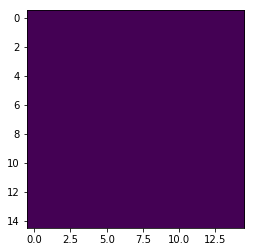

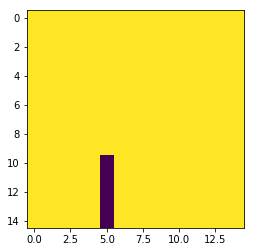

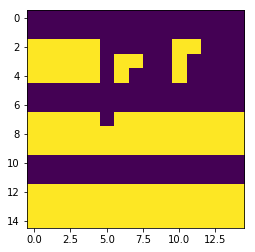

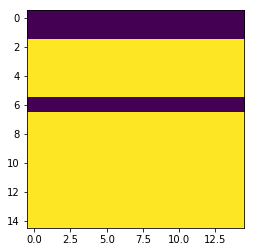

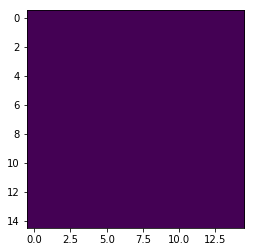

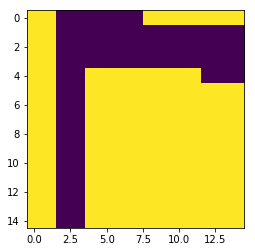

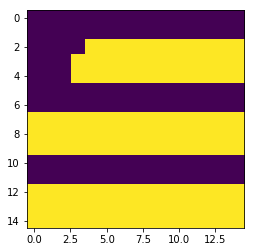

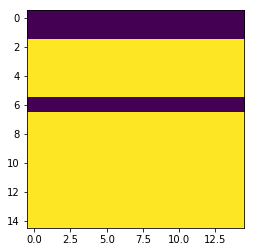

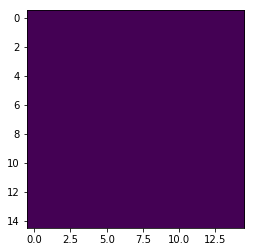

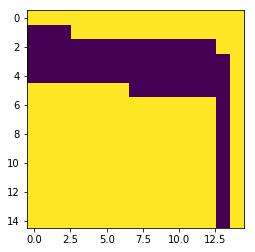

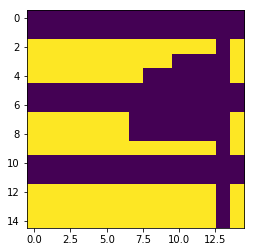

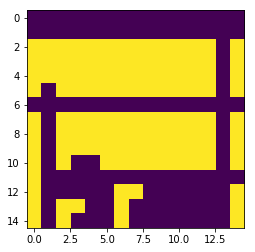

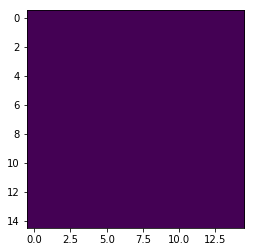

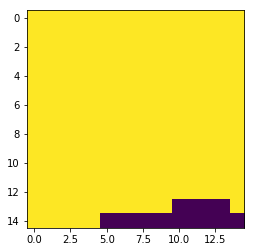

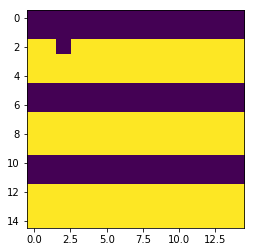

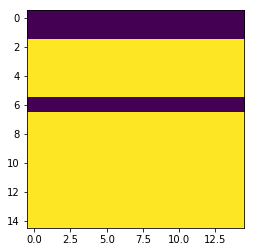

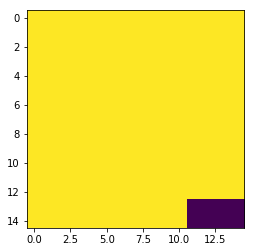

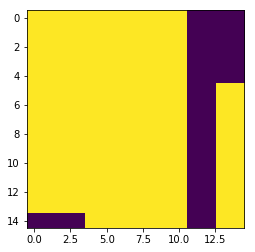

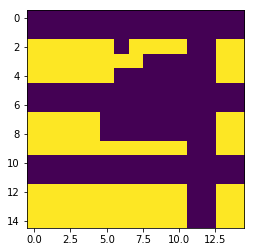

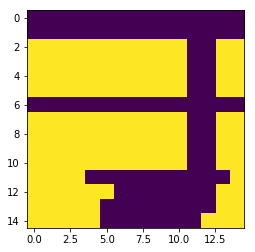

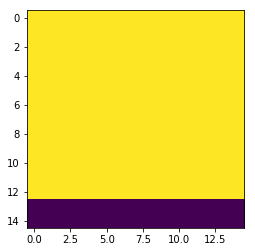

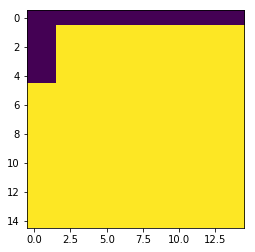

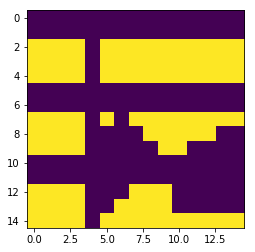

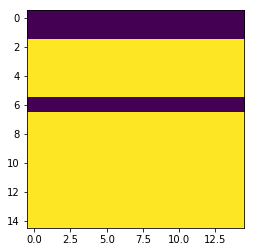

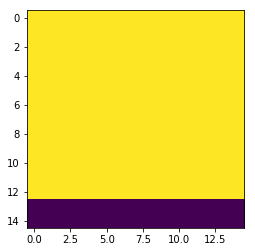

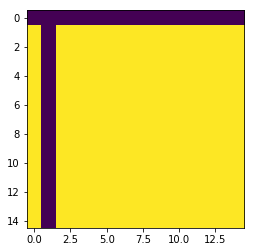

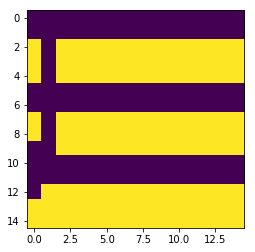

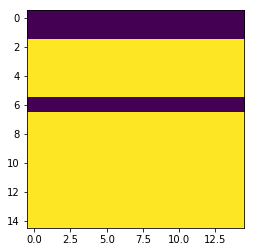

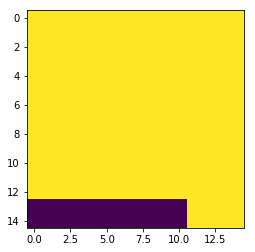

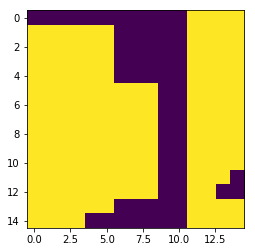

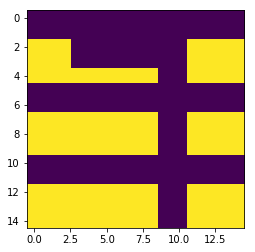

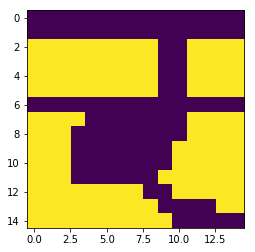

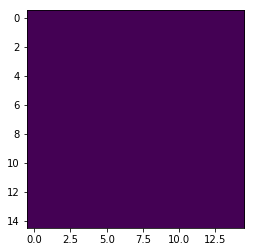

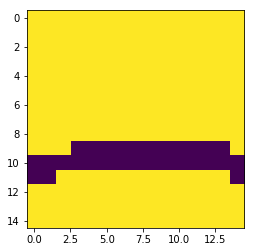

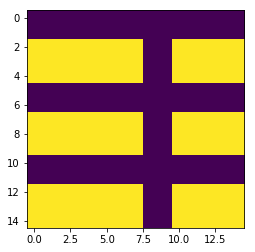

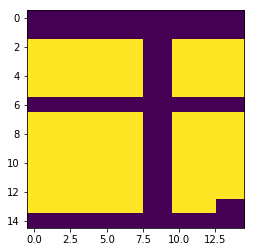

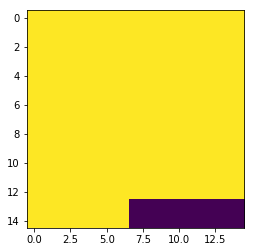

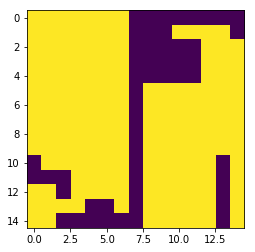

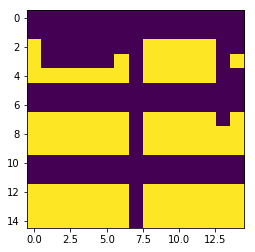

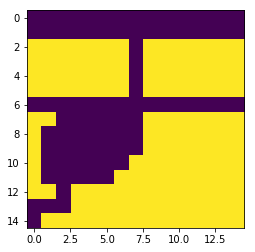

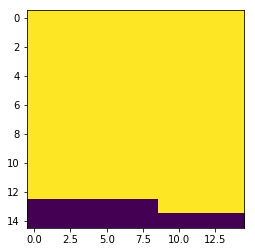

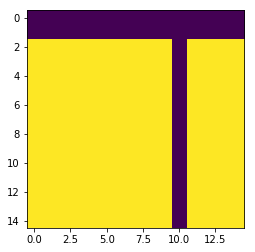

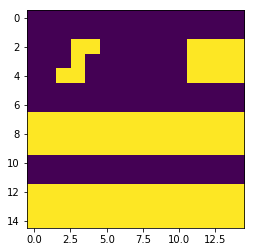

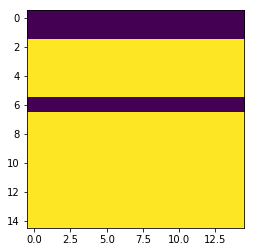

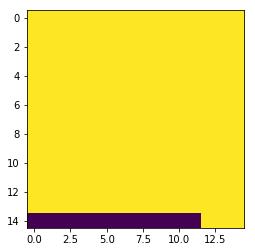

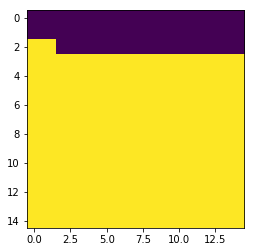

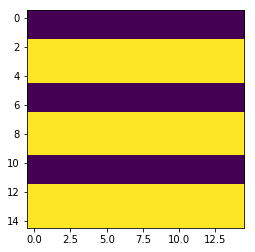

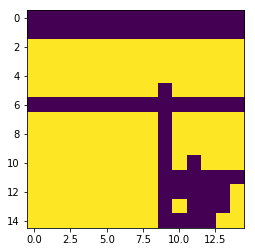

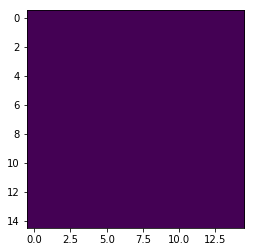

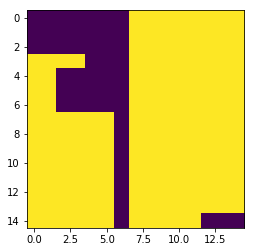

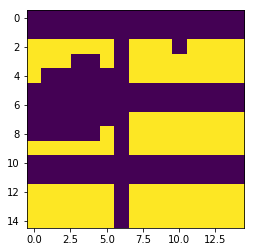

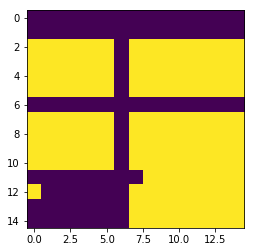

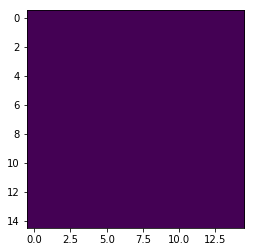

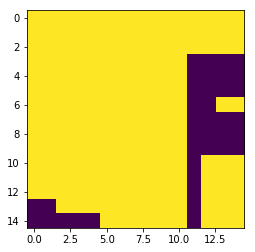

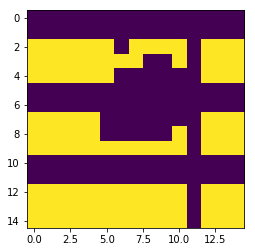

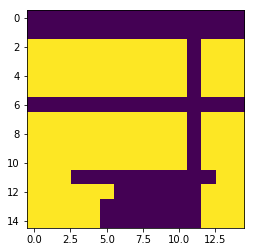

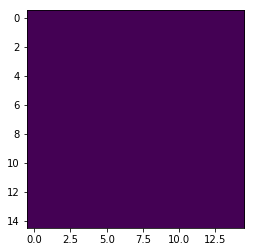

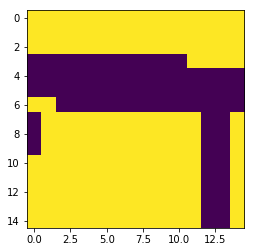

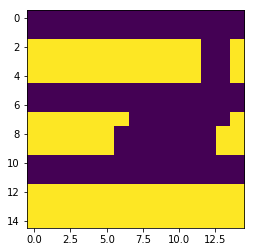

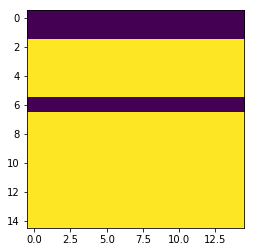

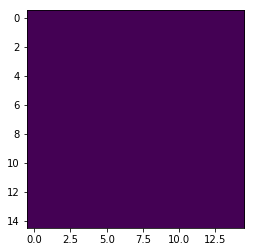

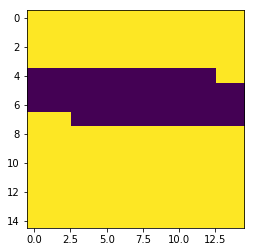

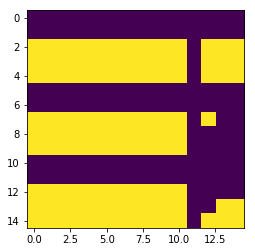

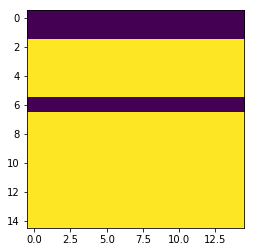

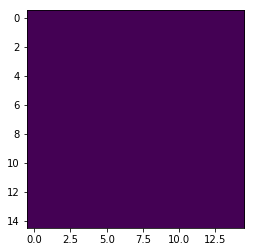

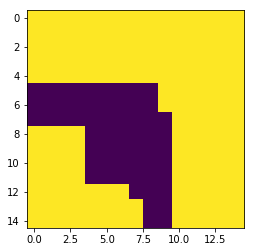

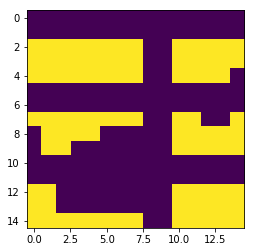

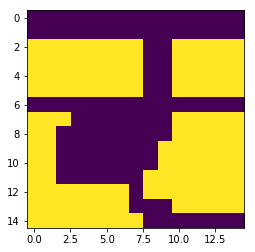

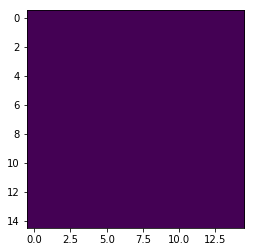

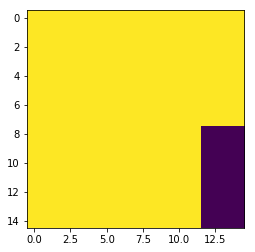

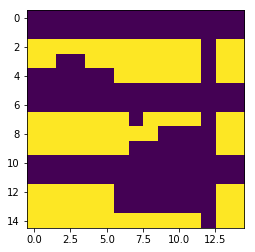

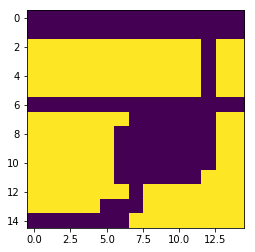

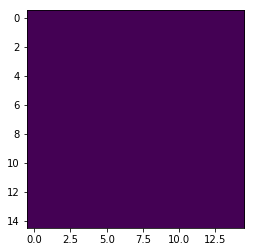

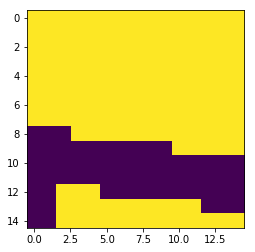

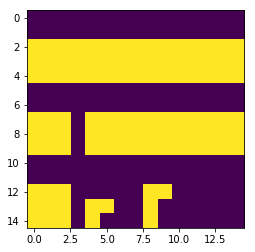

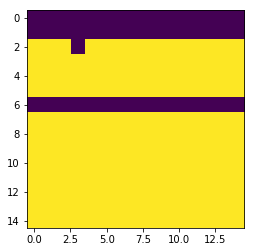

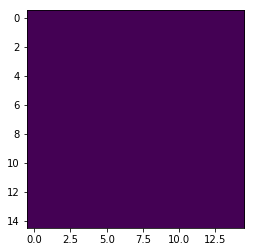

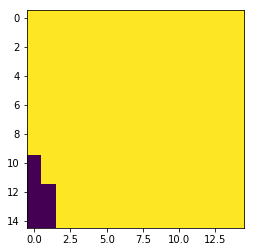

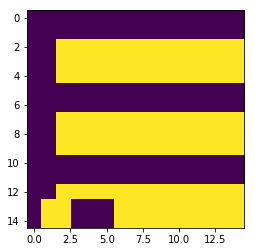

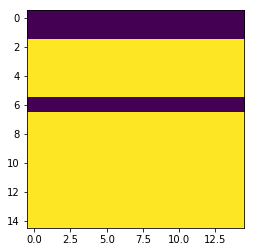

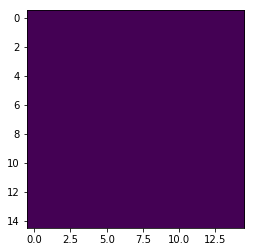

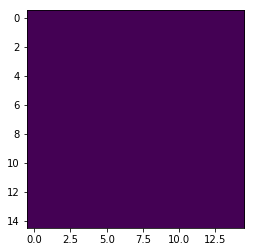

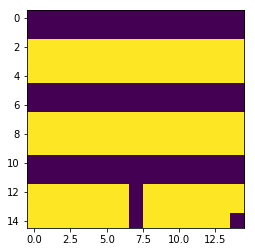

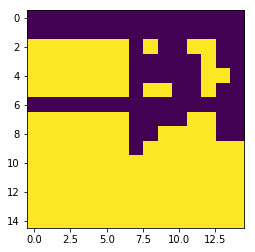

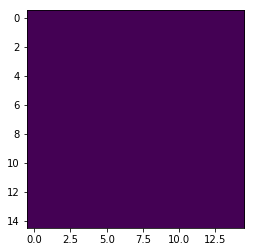

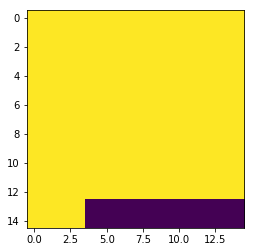

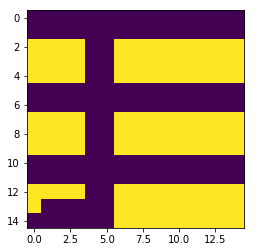

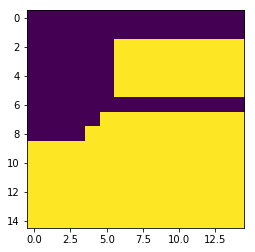

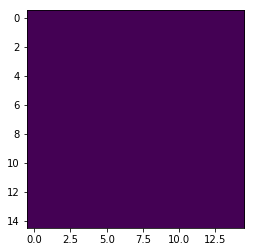

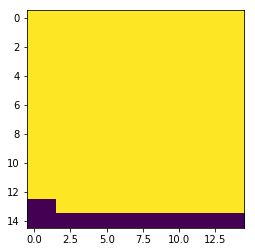

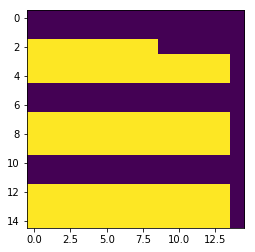

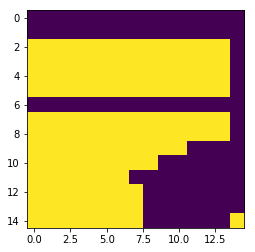

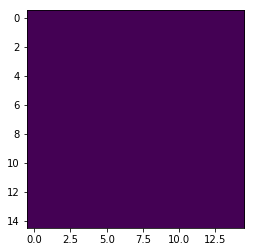

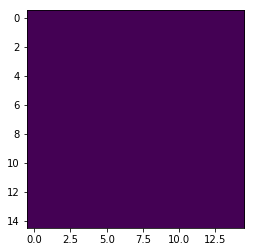

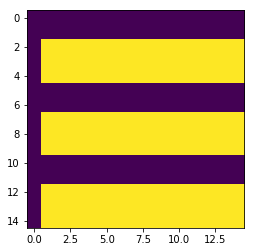

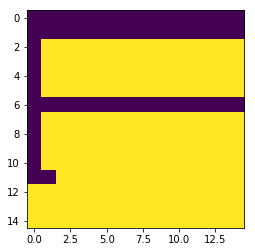

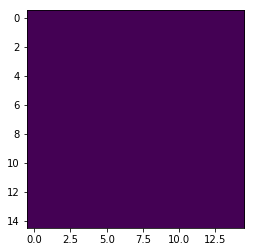

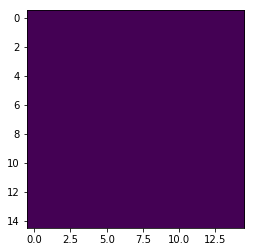

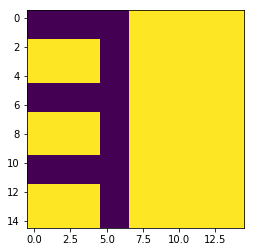

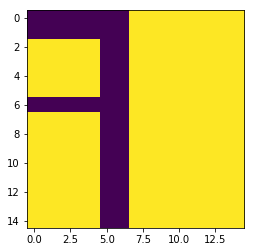

In [144]:
for column in column_windows:
    for window in column:
        plt.imshow(window)
        plt.show()

In [146]:
predicts = []

In [147]:
for column in column_windows:
    col_predicts = []
    for window in column:
        (height, width) = (window.shape[0], window.shape[1])
        #print("height: " + str(height))
        window_reshaped = window.reshape(1, height, width, 1)
        #print("reshaped to: " + str(window_reshaped.shape))
        #print(test_model.predict(window_reshaped))
        prediction = int(test_model.predict(window_reshaped)[0][0])
        if prediction == 1:
            col_predicts.append(window)
            
    predicts.append(col_predicts)

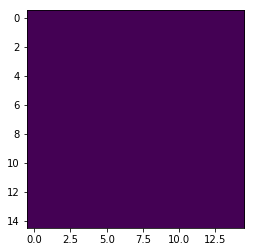

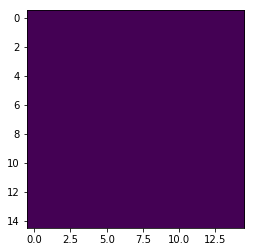

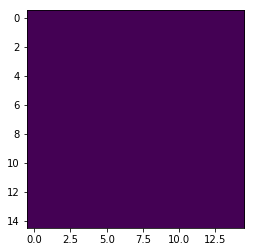

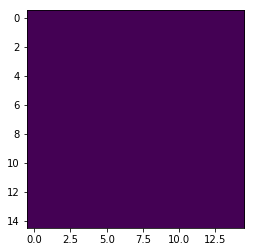

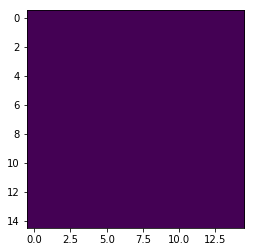

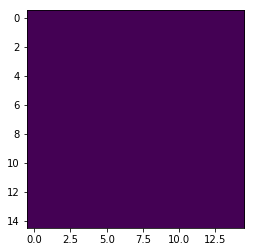

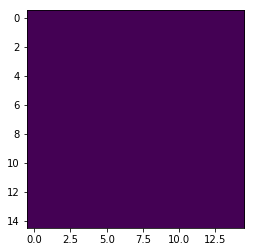

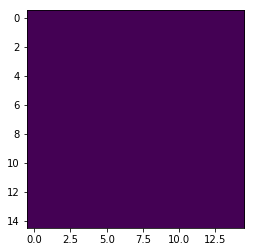

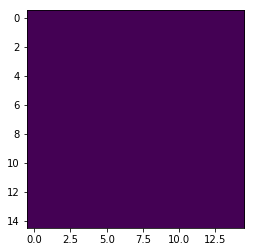

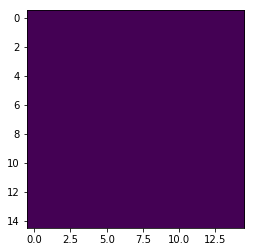

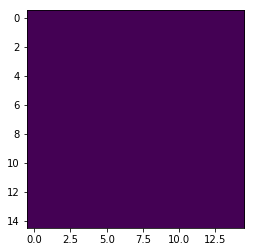

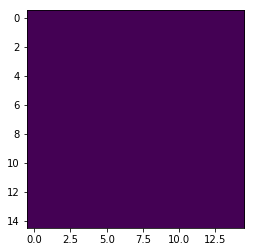

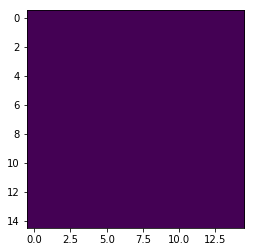

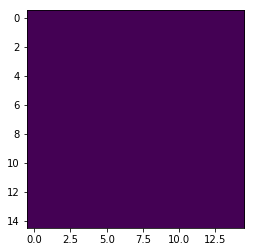

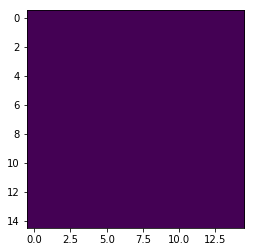

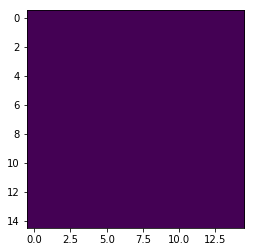

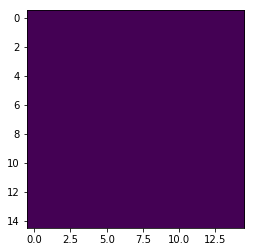

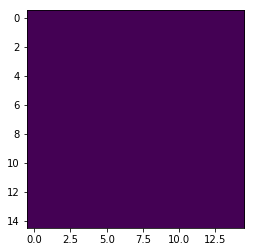

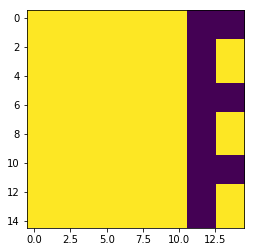

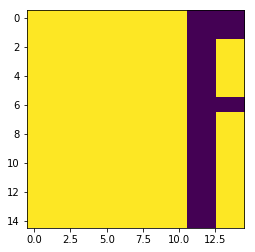

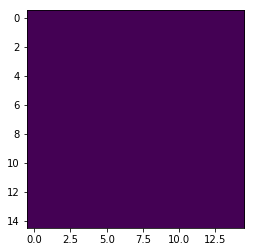

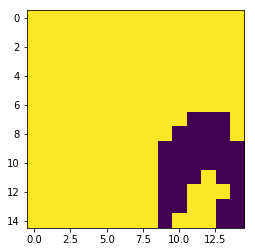

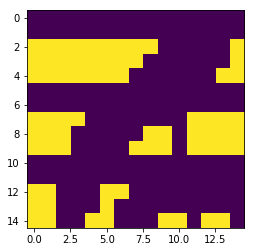

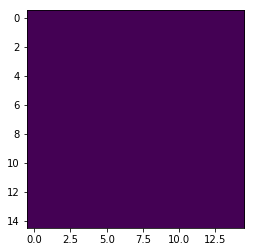

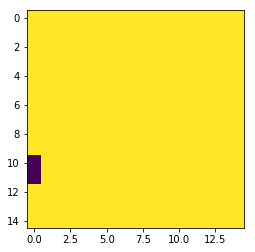

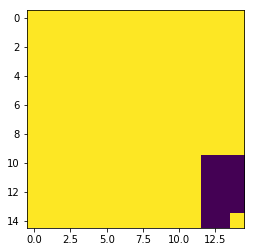

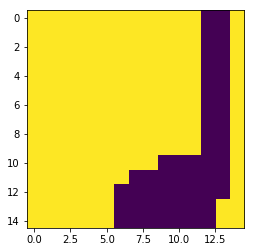

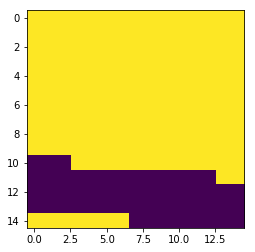

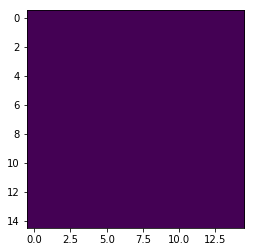

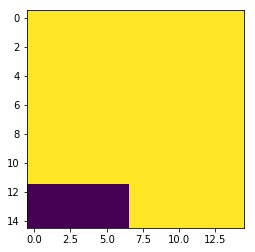

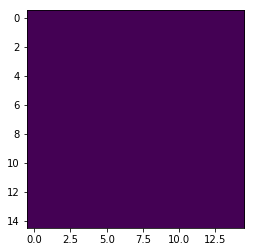

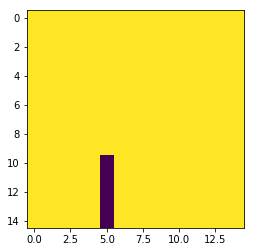

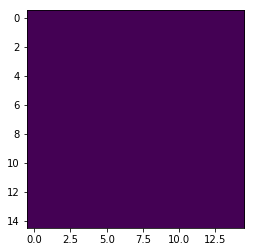

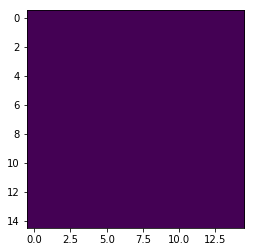

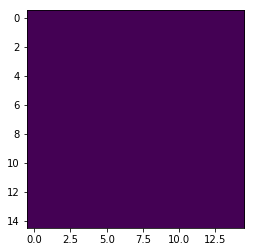

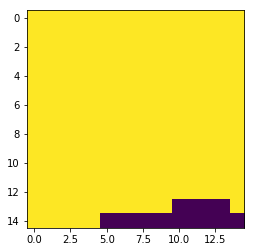

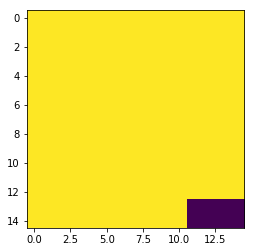

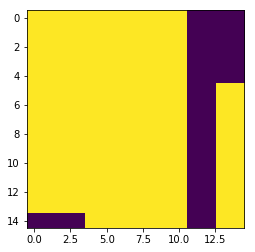

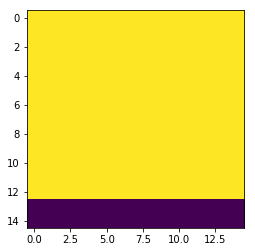

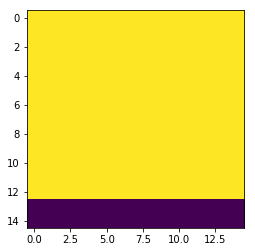

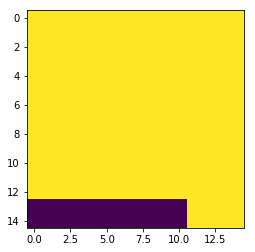

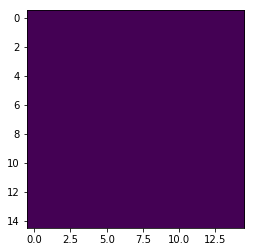

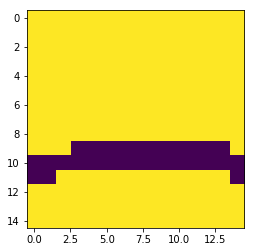

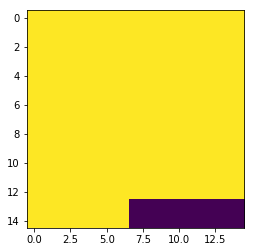

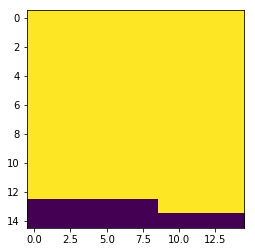

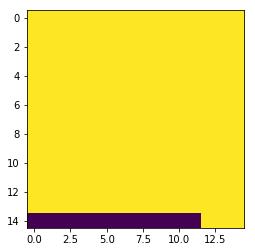

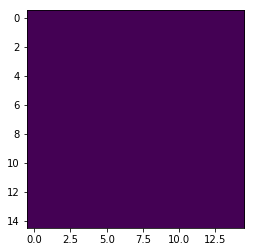

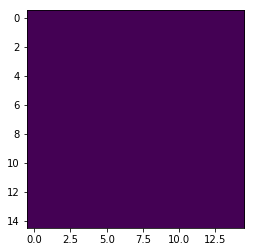

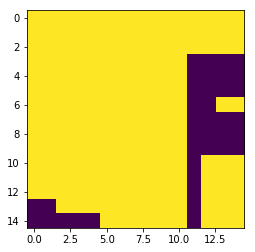

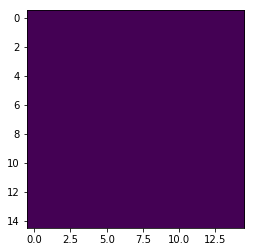

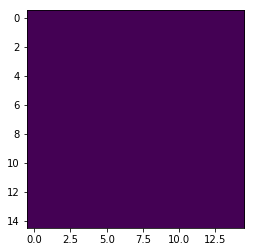

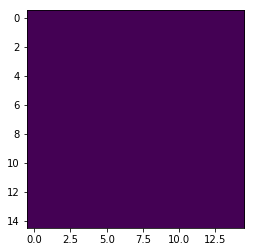

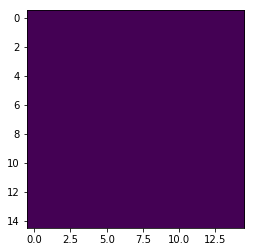

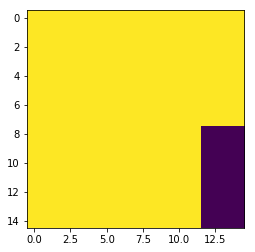

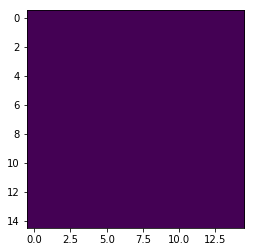

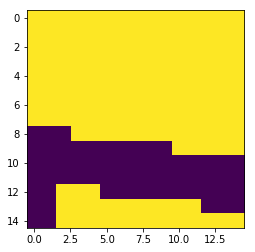

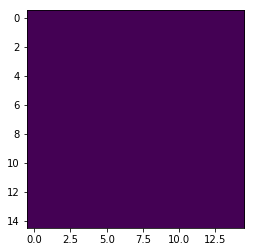

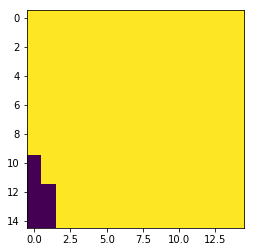

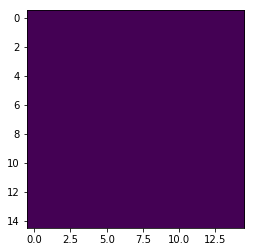

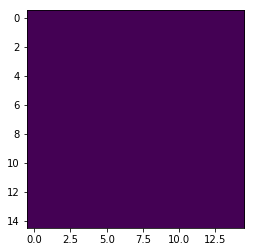

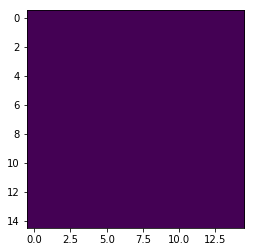

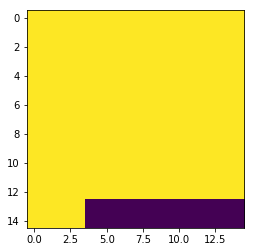

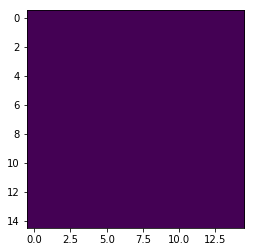

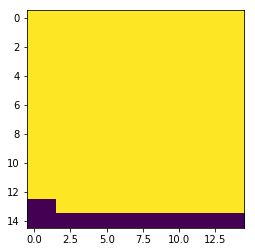

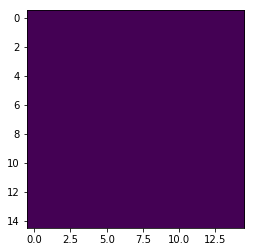

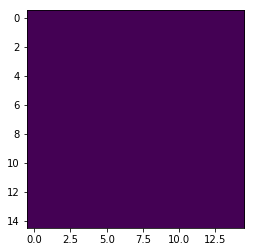

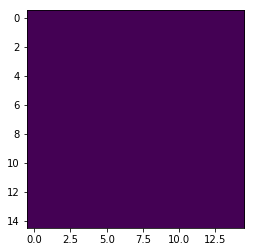

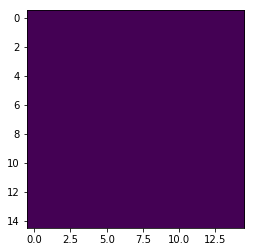

In [149]:
for column_predicts in predicts:
    for prediction in column_predicts:
        plt.imshow(prediction)
        plt.show()